In [195]:
#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from  nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import classify
from nltk.tokenize import TweetTokenizer
from nltk import NaiveBayesClassifier
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction import text
from sklearn.feature_extraction import stop_words
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, roc_auc_score
 
#Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


#ETC
import string
import pandas as pd
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import re
from wordcloud import WordCloud

#Keras
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Dropout, Input, Activation
#from tensorflow.keras.layers.recurrent import LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed
from tensorflow. keras.utils import plot_model

In [5]:
#Name columns
Columns  = ["sentiment", "user_id", "date", "query", "username", "text"]
Date = "ISO-8859-1"

In [6]:
#Read dataset
tweets = pd.read_csv("Data/tweets_new.csv", encoding = Date, names = Columns, error_bad_lines = False, skiprows=[323043])

In [7]:
#Filter by sentiment and tweets
tweets_df = tweets[['sentiment', 'text']]

In [8]:
#Map target value to sentiment strings
sentiment_mapping = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def map_sentiment_map(input):
    return sentiment_mapping[int(input)]

In [9]:
#apply sentiment mapping to all of the dataset
y_samp = tweets_df['sentiment'].apply(lambda x: map_sentiment_map(x))


In [10]:
#data cleaning(remove punctuation)
punct = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punct))


In [11]:
tweets['text'] = tweets_df['text'].apply(lambda text: remove_punctuation(text))

In [16]:
#Data cleaning
stemmer = PorterStemmer()
more_stop_words =  ('go', 'twitter','URL','USER', 'Twitter', 'TWITTER', 'Tweet', 'got', 'quot', 'amp', 'nan', 'you', 'time', 'im', 'ur', 'ill', 'just', 'a', 'and', 'twitter', 'tweet')
stop_words = text.ENGLISH_STOP_WORDS.union(more_stop_words)

def clean(text):
    #removed links and chars
    remove = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    #text = re.sub('https?://\S+|www\.\S+', '', text)
    url       = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user       = '@[^\s]+'
    alpha      = "[^a-zA-Z0-9]"
    text = re.sub(remove, ' ', str(text).lower()).strip()
    text = re.sub(url,' URL',text)
    text = re.sub(user,' USER',text)
    text = re.sub(alpha, " ", text)
    
    tokens = []
    for token in text.split(): 
        if token not in stop_words:
                tokens.append(stemmer.stem(token))
    return " ".join(tokens)

#remove not from stop word

In [17]:
tweets_clean = tweets.text.apply(lambda x: clean(x))

In [18]:
#Rename a few words
def cleaned(token):
    if token == 'sorri':
        return 'sorry'
    if token == 'r':
        return 'are'
    if token == 'realli':
        return 'really'
    if token == 'happi':
        return 'happy'
  
    return token

In [19]:
tweets_cleaned = tweets_clean.apply(lambda x: cleaned(x))

In [20]:
#Print top 10 most common words
from collections import Counter
cnt = Counter()
for text in tweets_cleaned.values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('day', 97911),
 ('good', 88644),
 ('work', 80774),
 ('like', 80340),
 ('love', 79767),
 ('dont', 64172),
 ('today', 63454),
 ('go', 61828),
 ('thank', 57390),
 ('want', 54485)]

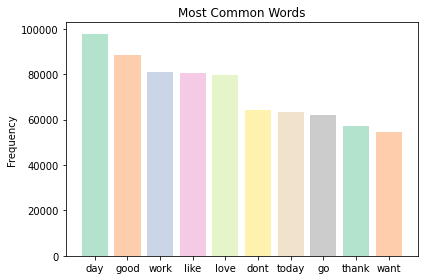

In [22]:
#Plot top 10 most common words
y = [count for tag, count in cnt.most_common(10)]
x = [tag for tag, count in cnt.most_common(10)]

my_cmap = plt.get_cmap("Pastel2")

plt.bar(x, y, color=my_cmap.colors)
plt.title("Most Common Words")
plt.ylabel("Frequency")
plt.savefig('Top_10_Words')
plt.tight_layout()

plt.rcParams['savefig.dpi'] = 300


In [24]:
#Filter by sentiment and text
tweets_username =tweets[['sentiment', 'text', 'username']]
sentiment_mapping_u = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def map_sentiment_u(input):
    return sentiment_mapping_u[int(input)]
tweets_username['sentiment'] = tweets['sentiment'].apply(lambda x: map_sentiment_u(x))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


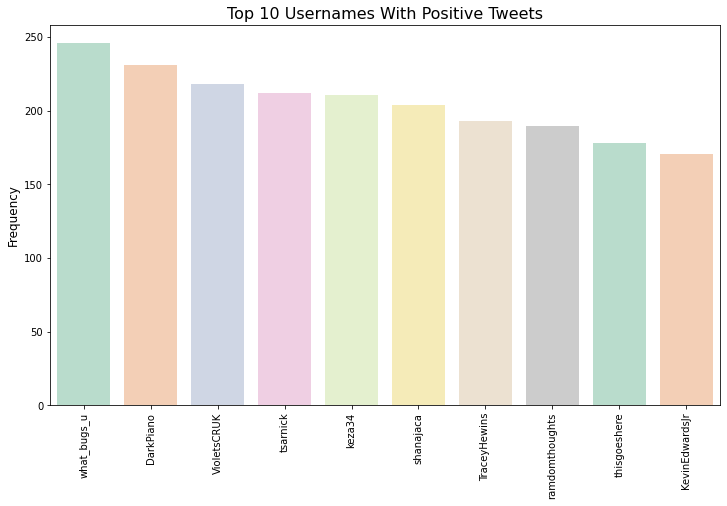

<Figure size 432x288 with 0 Axes>

In [30]:
#Plot 10 most common usernames
plt.figure(figsize=(12,7))
common_keyword=sns.barplot(x=tweets_username[tweets_username['sentiment']=='POSITIVE']['username'].value_counts()[:10].index, \
                           y=tweets_username[tweets_username['sentiment']=='POSITIVE']['username'].value_counts()[:10],palette='Pastel2')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Frequency',fontsize=12)
plt.title('Top 10 Usernames With Positive Tweets',fontsize=16)

plt.show()
plt.savefig('Top_10_Usernames')


In [75]:
#Print tweets by what_bugs_u
pd.set_option('display.max_colwidth',-1)
tweets[tweets['username']=='what_bugs_u'].head()


,sentiment,text,username
1141441,POSITIVE,"@JadeMcCray why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",what_bugs_u
1141626,POSITIVE,"@cadmiumcannibal why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",what_bugs_u
1141648,POSITIVE,"@RonanDosSantos why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",what_bugs_u
1141674,POSITIVE,"@ShayMac28 why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",what_bugs_u
1142667,POSITIVE,"@lynnsdecor why limit your story to 140 chr. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",what_bugs_u


In [31]:
#Join sentiment and text
tweets_concat = pd.concat([tweets_cleaned, y_samp], axis=1)

In [182]:
#sample dataset randomly
samp2 = tweets_concat.sample(n=500000,replace=False)


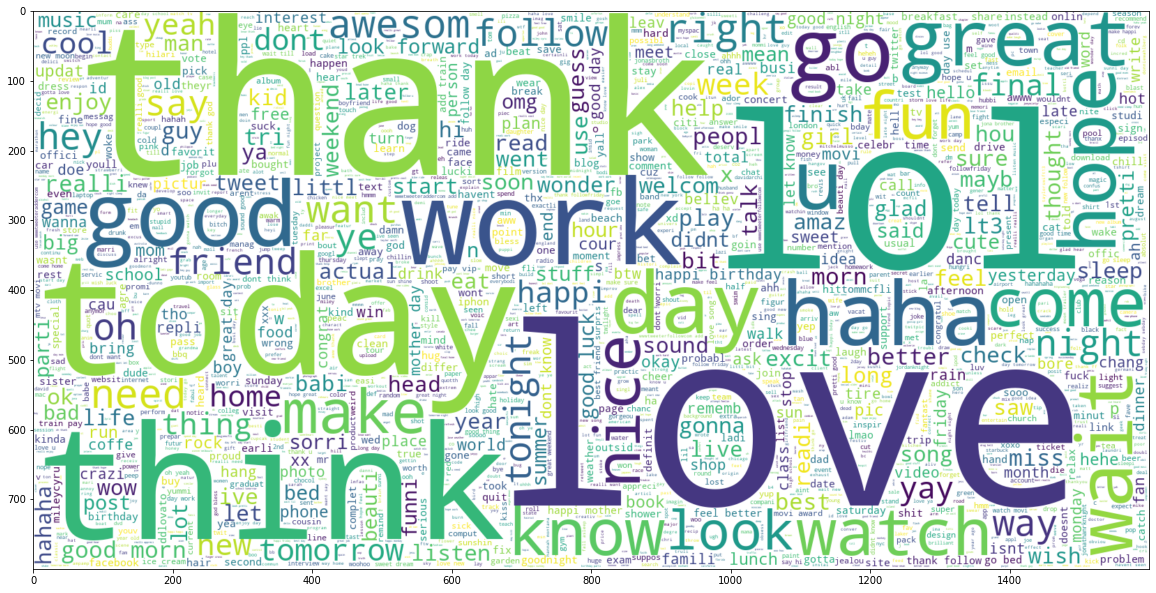

In [193]:
#Positive word cloud
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, background_color="white").generate(" ".join(samp2[samp2['sentiment'] == 'POSITIVE'].text))
#plt.savefig('Images/Positive_Word_Cloud')
plt.imshow(wc , interpolation = 'bilinear')


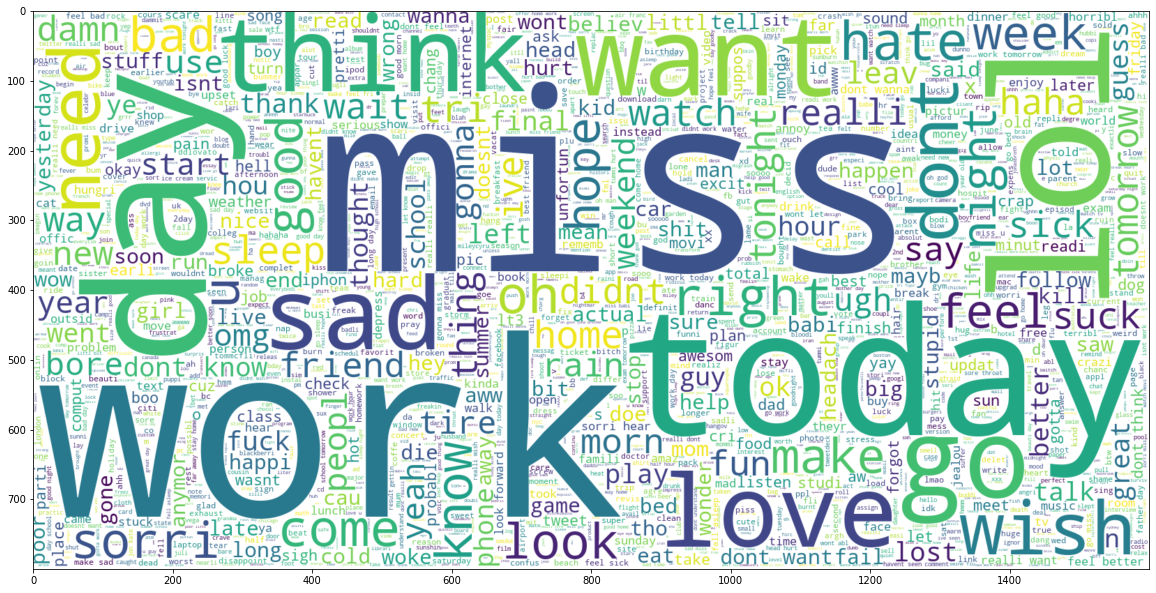

In [57]:
#Negative word clout
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, background_color="white").generate(" ".join(samp[samp['sentiment'] == 'NEGATIVE'].text))
plt.savefig('Images/Negative_Word_Cloud')

plt.imshow(wc , interpolation = 'bilinear')


In [42]:
#vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.85, min_df=1, max_features=5000, ngram_range=(1,3))
#X = vectorizer.fit_transform(tweets_concat['text'])

In [30]:
#samp_csv = tweets_concat.to_csv('/tf/Desktop/Class/Twitter-Sentiment-Analysis/samp.csv')

In [235]:
#samp_c = pd.read_csv('/tf/Desktop/Class/Twitter-Sentiment-Analysis/App/samp.csv')

In [69]:
#Use TfIDF vectorizer and train_test_split
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)

X = vectorizer.fit_transform(tweets_concat['text'])

y = tweets_concat['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=3)


In [70]:
#MNB Model accuracy score
multi_naive_bayes = MultinomialNB()
fitted = multi_naive_bayes.fit(X_train, y_train)
np.mean(fitted.predict(X_test) == y_test)


0.7761411941031306

In [65]:
#Predict MNB
y_trainpred = multi_naive_bayes.predict(X_train)
y_pred = multi_naive_bayes.predict(X_test)

print('Train Accuracy:', accuracy_score(y_train, y_trainpred))
print('Test Accuracy:', accuracy_score(y_test, y_pred))

Train Accuracy: 0.8191117878148446
Test Accuracy: 0.7753401294623823


In [46]:
#Predict probability of sentiment
y_pred = multi_naive_bayes.predict_proba(X_test)
y_pred
for prob in y_pred:
    max_index = np.argmax(prob)
    probability = prob[max_index]
print(probability)

0.8851793257035452


In [48]:
#Function for predictions
def predict(text):
  
    text_ = vectorizer.transform([text])
    score = multi_naive_bayes.predict_proba(text_)
    for prob in score:
        max_index = np.argmax(prob)
        probability = prob[max_index]
        if max_index == 1:
            print('positive')
        else:
            print ('negative')
        
    return probability

In [59]:
#Test model w/ new text
a = predict('i love you')
print(a)

positive
0.8257278133458419


In [161]:
confusion_matrix(y_test, y_pred)

array([[28075,  9430],
       [ 7958, 31934]])

In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.75      0.76     37505
    POSITIVE       0.77      0.80      0.79     39892

   micro avg       0.78      0.78      0.78     77397
   macro avg       0.78      0.77      0.77     77397
weighted avg       0.78      0.78      0.78     77397



In [157]:
accuracy_score(y_test, y_pred) # TP + TN/ TP + TN + FP + FN

0.7753401294623823

In [167]:
#Confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

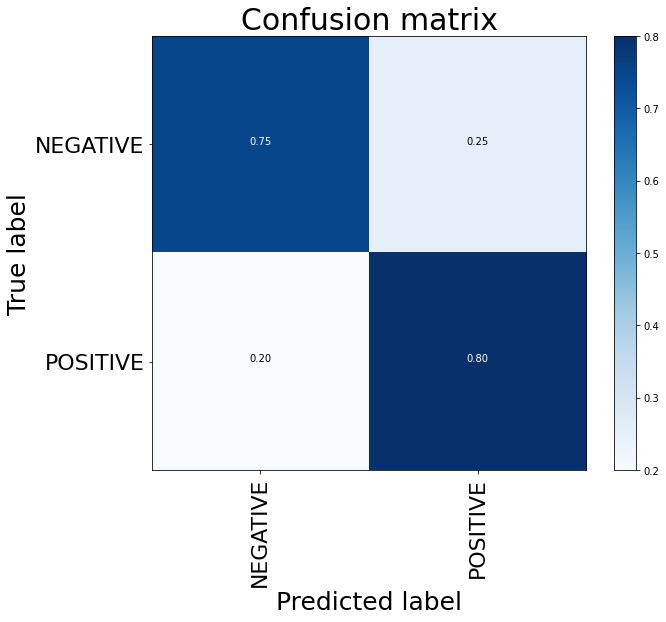

<Figure size 432x288 with 0 Axes>

In [170]:

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=tweets_concat['sentiment'].unique(), title="Confusion matrix")
plt.show()
plt.savefig('CF_MNB')

In [208]:
#Vectorize tweets and run train, test split
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_l = vectorizer.fit_transform(tweets_concat['text'])
y_l= tweets_concat['sentiment']

X_trainl, X_testl, y_trainl, y_testl = train_test_split(X_l, y_l, test_size=0.05, random_state=4)


In [228]:
LR = LogisticRegression()
LR.fit(X_trainl, y_trainl)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [229]:
accuracies = cross_val_score(estimator = LR, X = X_trainl, y = y_trainl, cv = 10) 
accuracies.mean()

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.788106577761605

In [240]:
y_testl = y_testl.replace(1, 'POSITIVE')
y_testl = y_testl.replace(0, 'NEGATIVE')

In [232]:
y_pred_l = LR.predict(X_testl)

In [241]:
confusion_matrix(y_testl, y_pred_l)

array([[27892,  9265],
       [ 7088, 33152]])

In [242]:
print(classification_report(y_testl, y_pred_l))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.75      0.77     37157
    POSITIVE       0.78      0.82      0.80     40240

   micro avg       0.79      0.79      0.79     77397
   macro avg       0.79      0.79      0.79     77397
weighted avg       0.79      0.79      0.79     77397



In [243]:
#Predict LR
y_trainpredl = LR.predict(X_trainl)
y_predl = LR.predict(X_testl)

print('Train Accuracy:', accuracy_score(y_trainl, y_trainpredl))
print('Test Accuracy:', accuracy_score(y_testl, y_predl))

Train Accuracy: 0.8291415254531199
Test Accuracy: 0.7887127408039071


In [216]:
#Function for predictions
def predictl(text):
  
    text_ = vectorizer.transform([text])
    score = LR.predict_proba(text_)
    for prob in score:
        max_index = np.argmax(prob)
        probability = prob[max_index]
        if max_index == 1:
            print('positive')
        else:
            print ('negative')
        
    return probability

In [217]:
a = predictl('i love')
print(a)

positive
0.9931174553739025


In [223]:
y_testl = y_testl.replace('POSITIVE', 1)
y_testl = y_testl.replace('NEGATIVE', 0)
y_predl = y_testl.replace('POSITIVE', 1)
y_predl = y_testl.replace('NEGATIVE', 0)

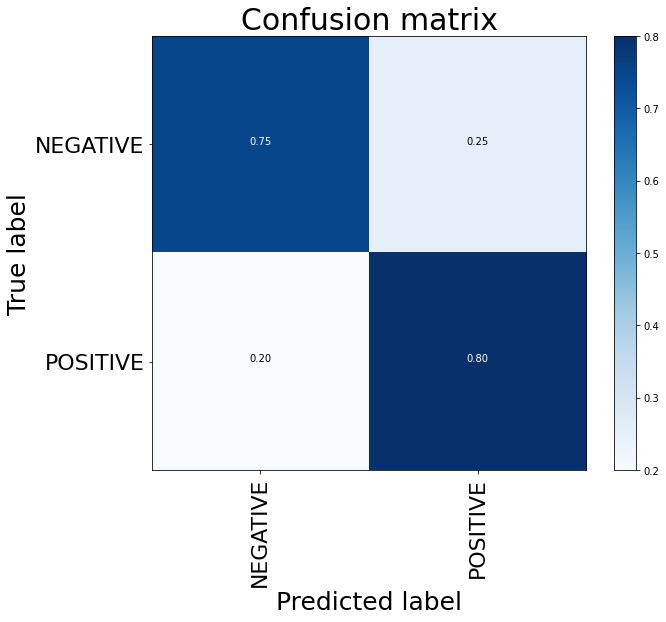

In [244]:
#Logistic Regression Confusion Matrix
cnf_matrix_LR = confusion_matrix(y_testl, y_predl)
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=tweets_concat['sentiment'].unique(), title="Confusion matrix")
plt.show()
